Created on Fri Sep  1 18:51:52 2023
Updated in Oct 2024
@author: Milan Salek

This script creates a plot that shows the main components of the 
radiation imbalance as measured by CERES project

The CERES data are from the web site:
https://ceres.larc.nasa.gov/data/#ebaftoa-level-3

Order EBAF-TOA, Level 3b data 
(Observed TOA all-sky and clear-sky fluxes; CERES-MODIS cloud properties. 
Clear-sky for cloud free areas of 1°x1° region.)

Some sources of algorithms for beginners in xarray and NetCDF:
https://earth-env-data-science.github.io/assignments/basic_xarray.html
https://fabienmaussion.info/climate_system/week_02/01_Lesson_NetCDF_Data.html

The Gistemp data are from https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Monthly_Mean_Global_Surface_Temperature/graph.txt
You have to adjust/edit the dataset to the correct time range according to the CERES dataset
starting by 2000.21 (March 2000) and ending by the same month as the CERES data
See also # Defining the start and end date below!

The global average is computed by the same algorithm as the global average of
weighted temperature:
https://docs.xarray.dev/en/stable/examples/area_weighted_temperature.html

All the resulting values are rolling/moving average!


In [17]:

import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
import netCDF4 as nc
from scipy import signal
from datetime import datetime,timedelta

avg_temp_Earth = 14.5  # rather arbitrary, not important
end_year=2026  # for the max limit of the final graphs
# kernel (number of months for moving averages)
kernel=12


In [18]:
fpath_ceres = "./CERES_EBAF-TOA_Ed4.2.1_Subset_200003-202507.nc"   # NetCDF file with the radiation fluxes, needs to be downloaded manually
ds = xr.open_dataset(fpath_ceres, engine='netcdf4')

Setting datetime limits of the data series by strptime warkaround. As the datetime format is too fine, we have to limit the datetime to seconds. %Y-%m-%dT%H:%M:%S.%f expects exactly 6 digits for microseconds, but the numpy.datetime64 offers 9 digits (try print (ds.time.values[0], type(ds.time.values[0]))). Therefore The .000000000 in the string needs to be trimmed to .000000 for strptime to work

In [19]:
time_values = ds.time.values
start_time_string = np.datetime_as_string(time_values[0])
end_time_string = np.datetime_as_string(time_values[-1])
start_time = datetime.strptime(start_time_string[:26],"%Y-%m-%dT%H:%M:%S.%f")
end_time = datetime.strptime(end_time_string[:26],"%Y-%m-%dT%H:%M:%S.%f")

In [20]:
print(start_time_string, start_time, end_time) 

2000-03-15T00:00:00.000000000 2000-03-15 00:00:00 2025-07-15 00:00:00


As the gistemp values are in decimal year value (..., 2025.04,2025.13,2025.21,...), we have to convert it into this format:

In [21]:
def datetime64_to_decimal_year(dt):
    # Convert numpy.datetime64 to datetime.datetime
    # dt = np.datetime_as_string(dt64, unit='s')  # Convert to string
    # dt = datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")  # Parse string

    year_start = datetime(dt.year, 1, 1)
    year_end = datetime(dt.year + 1, 1, 1)
    year_length = (year_end - year_start).total_seconds()
    seconds_into_year = (dt - year_start).total_seconds()
    
    decimal_year = dt.year + seconds_into_year / year_length
    return decimal_year


start_year_decimal = datetime64_to_decimal_year(start_time)
end_year_decimal = datetime64_to_decimal_year(end_time)

In [22]:
# Reading the time series downloaded from GISTEMP NASA:
# https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Monthly_Mean_Global_Surface_Temperature/graph.csv
# The file gistemp_2024-04_reduced.csv must contain the same time span as
# the CERES_EBAF*.nc file
# gistemp_monthly_temperatures = []
# gistemp_year_decimal = []

import requests

def decimalYear2datetime(decimalYear):
    year = int(decimalYear)
    rem = decimalYear - year
    base = datetime(year, 1, 1)
    date_time = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    year_aux, month_aux = date_time.year, date_time.month
    return (datetime(year=year_aux,month=month_aux, day=15))

url = 'https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Monthly_Mean_Global_Surface_Temperature/graph.csv'
r = requests.get(url)

In [23]:
# Reading the time series downloaded from GISTEMP NASA:
# https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Monthly_Mean_Global_Surface_Temperature/graph.txt
# The file gistemp_2024-04_reduced.csv must contain the same time span as
# the CERES_EBAF*.nc file
# gistemp_monthly_temperatures = []
# gistemp_year_decimal = []

def decimalYear2datetime(decimalYear):
    year = int(decimalYear)
    rem = decimalYear - year
    base = datetime(year, 1, 1)
    date_time = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    year_aux, month_aux = date_time.year, date_time.month
    return (datetime(year=year_aux,month=month_aux, day=15))

df_gistemp_monthly_temperatures = pd.read_csv('graph.csv', skiprows=1, header=0)
df_gistemp_monthly_temperatures.drop(["Station", "Land_Only", "Open_Ocean"], axis="columns", inplace=True)
df_gistemp_monthly_temperatures.rename(columns = {"Year+Month":"time", "Land+Ocean":"t"}, inplace=True)
df_gistemp_monthly_temperatures.head(5)
df_gistemp_monthly_temperatures = df_gistemp_monthly_temperatures[df_gistemp_monthly_temperatures.time >= (start_year_decimal - 0.05)]
df_gistemp_monthly_temperatures = df_gistemp_monthly_temperatures[df_gistemp_monthly_temperatures.time <= (end_year_decimal + 0.05)]
print (start_year_decimal, end_year_decimal)
start_date_gistemp = decimalYear2datetime(start_year_decimal)
end_date_gistemp = decimalYear2datetime(end_year_decimal)
print (start_date_gistemp, end_date_gistemp)


2000.2021857923498 2025.5342465753424
2000-03-15 00:00:00 2025-07-15 00:00:00


In [24]:
df_gistemp_monthly_temperatures.tail(5)

,time,t
1742,2025.21,1.36
1743,2025.29,1.23
1744,2025.38,1.07
1745,2025.46,1.05
1746,2025.54,1.01


In [25]:
# added 20 days as we need to end with the first month with no data
time = pd.date_range(start=start_date_gistemp, end=end_date_gistemp + timedelta(days=20), freq='MS')
# Create an xarray DataArray
gistemp_array = xr.DataArray(
    df_gistemp_monthly_temperatures["t"],
    coords=[time],
    dims=["time"],
    name="monthly_time_series_data"
)


In [26]:
# Smoothing of th Gistemp data by kernel-month moving average
gistemp_months_smoothed = \
    gistemp_array.rolling(time = kernel, 
            center = False).mean()

gistemp_months_smoothed

<xarray.DataArray 'monthly_time_series_data' (time: 305)> Size: 2kB
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.39833333, 0.39833333, 0.39333333, 0.41166667,
       0.42166667, 0.43833333, 0.44416667, 0.455     , 0.47416667,
       0.50916667, 0.53166667, 0.55833333, 0.5875    , 0.615     ,
       0.62166667, 0.6275    , 0.62833333, 0.63083333, 0.63416667,
       0.645     , 0.64833333, 0.6375    , 0.62833333, 0.62583333,
       0.60916667, 0.58583333, 0.58333333, 0.58      , 0.575     ,
       0.57166667, 0.58083333, 0.57916667, 0.59416667, 0.58916667,
       0.61416667, 0.60083333, 0.6125    , 0.615     , 0.62      ,
       0.60083333, 0.59833333, 0.57166667, 0.55583333, 0.545     ,
       0.53583333, 0.5525    , 0.5325    , 0.54583333, 0.53583333,
       0.545     , 0.55      , 0.57166667, 0.58833333, 0.6175    ,
       0.63      , 0.64833333, 0.66083333, 0.66166667, 0.67583333,
       0.66083333, 0.67166667, 0.6625    , 0.645     , 0.6325    ,
       0.63416667, 0.62833333, 0.63666667, 0.63166667, 0.62583333,
       0.625     , 0.635     , 0.6725    , 0.67      , 0.67666667,
       0.70166667, 0.71833333, 0.71416667, 0.71833333, 0.71      ,
       0.705     , 0.69583333, 0.68416667, 0.65916667, 0.59916667,
       0.5725    , 0.575     , 0.55666667, 0.54083333, 0.53083333,
...
       0.95166667, 0.94833333, 0.94      , 0.93833333, 0.92583333,
       0.91333333, 0.915     , 0.91166667, 0.9175    , 0.90083333,
       0.8775    , 0.85416667, 0.84916667, 0.84083333, 0.845     ,
       0.84583333, 0.83833333, 0.8425    , 0.8525    , 0.84833333,
       0.8475    , 0.85666667, 0.865     , 0.88916667, 0.9       ,
       0.90416667, 0.91583333, 0.92416667, 0.93833333, 0.94916667,
       0.9475    , 0.96083333, 0.97666667, 0.99666667, 1.02083333,
       1.02166667, 1.03083333, 1.04166667, 1.0425    , 1.03916667,
       1.03166667, 1.03416667, 1.02416667, 1.0325    , 1.00583333,
       0.97583333, 0.92583333, 0.90166667, 0.87166667, 0.855     ,
       0.84916667, 0.85166667, 0.8475    , 0.84416667, 0.85333333,
       0.83916667, 0.84583333, 0.85416667, 0.875     , 0.8875    ,
       0.89333333, 0.8975    , 0.90416667, 0.90583333, 0.9175    ,
       0.915     , 0.91333333, 0.8975    , 0.89166667, 0.88833333,
       0.895     , 0.91083333, 0.92416667, 0.9325    , 0.94583333,
       0.96666667, 0.98666667, 1.03583333, 1.0675    , 1.12416667,
       1.17166667, 1.20333333, 1.2425    , 1.25583333, 1.2825    ,
       1.29916667, 1.30916667, 1.31      , 1.31916667, 1.29833333,
       1.29833333, 1.28833333, 1.28      , 1.29      , 1.27416667,
       1.27166667, 1.265     , 1.25916667, 1.24666667, 1.23083333])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-04-01 2000-05-01 ... 2025-08-01

In [27]:
ds

<xarray.Dataset> Size: 553MB
Dimensions:            (lon: 360, lat: 180, time: 305)
Coordinates:
  * lon                (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * lat                (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time               (time) datetime64[ns] 2kB 2000-03-15 ... 2025-07-15
Data variables:
    toa_sw_all_mon     (time, lat, lon) float32 79MB ...
    toa_lw_all_mon     (time, lat, lon) float32 79MB ...
    toa_net_all_mon    (time, lat, lon) float32 79MB ...
    toa_sw_clr_c_mon   (time, lat, lon) float32 79MB ...
    toa_lw_clr_c_mon   (time, lat, lon) float32 79MB ...
    toa_net_clr_c_mon  (time, lat, lon) float32 79MB ...
    solar_mon          (time, lat, lon) float32 79MB ...
Attributes:
    title:        CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly...
    institution:  NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.2.1; Release Date November 25, 2024
    DOI:          10.5067/TERRA-AQUA-NOAA20/CERES/EBAF-TOA_L3B004.2.1

In [28]:
# CERES data preparation:
sw_ = ds.toa_sw_clr_c_mon  # Short-wave outgoing radiation

# Crop data for latitudes greater than or equal to 30 degrees north and less than or equal to 40 degrees north,
# and for latitudes greater than or equal to 30 degrees south and less than or equal to 40 degrees south
# cropped_ds = ds.sel(latitude=slice(30, 40)).where(ds.latitude <= 40,
#                     drop=True).where(ds.latitude >= -40, drop=True)

#526https://gis.stackexchange.com/questions/353698/how-to-clip-an-xarray-to-a-smaller-extent-given-the-lat-lon-coordinates
sw = sw_.sel(lat=slice(80,90) and slice(-90,-70))

solar_incmg = ds.solar_mon   # Solar incoming radiation
lw_ = ds.toa_lw_clr_c_mon # Long-wave outgoing radiation
lw = lw_.sel(lat=slice(80,90) and slice(-90,-70))

toa_net = ds.toa_net_all_mon

# Computation of weights that are proportional to cos(lat)
def cosine_function(x):
    return np.cos(np.radians(x))

result = xr.apply_ufunc(cosine_function, ds['lat'], keep_attrs=True)
ds['cosine_lat'] = result

# Computing the weighted average
weights = np.cos(np.deg2rad(ds.lat))
sw_weighted = sw.weighted(weights)
lw_weighted = lw.weighted(weights)
toa_net_weighted = toa_net.weighted(weights)
solar_incmg_weighted = solar_incmg.weighted(weights)

sw_weighted_mean = sw_weighted.mean(("lon", "lat")) # Computing of the areal (global) mean (short-wave outhoing) 
lw_weighted_mean = lw_weighted.mean(("lon", "lat")) # Computing of the areal (global) mean (long-wave outgoing) 
toa_net_weighted_mean = toa_net_weighted.mean(("lon", "lat")) # Computing of the areal (global) mean (radiation balance, difference) 
solar_incmg_weighted_mean = solar_incmg_weighted.mean(("lon", "lat")) # Computing of the areal (global) mean (solar incoming) 

# Moving average of the global mean component of the radiation values: 
sw_weighted_mean_smoothed = \
    sw_weighted_mean.rolling(time = kernel, 
                             center = True).mean()    
   
lw_weighted_mean_smoothed = \
    lw_weighted_mean.rolling(time = kernel, 
                             center = True).mean()    

toa_net_weighted_mean_smoothed = \
    toa_net_weighted_mean.rolling(time = kernel, 
                             center = True).mean()

solar_incmg_weighted_mean_smoothed = \
    solar_incmg_weighted_mean.rolling(time = kernel, 
                             center = True).mean()    
    


In [29]:
sw_weighted_mean_smoothed

<xarray.DataArray 'toa_sw_clr_c_mon' (time: 305)> Size: 1kB
array([       nan,        nan,        nan,        nan,        nan,
              nan, 118.69488 , 118.80587 , 118.746765, 118.73791 ,
       118.73791 , 118.73791 , 118.58886 , 118.570305, 118.43386 ,
       118.30907 , 118.031784, 117.68219 , 117.83495 , 118.67113 ,
       118.84155 , 118.86147 , 118.86147 , 118.86147 , 118.92361 ,
       118.9407  , 118.474846, 118.02429 , 118.14209 , 118.44005 ,
       118.541435, 117.61874 , 117.474396, 117.45247 , 117.45247 ,
       117.45247 , 117.32875 , 117.1481  , 117.63253 , 117.774315,
       117.63612 , 117.66555 , 117.49694 , 117.34161 , 117.342155,
       117.3351  , 117.3351  , 117.3351  , 117.37716 , 117.84581 ,
       119.630974, 119.96932 , 119.68395 , 119.04754 , 118.638596,
       118.87325 , 118.80816 , 118.82736 , 118.82736 , 118.82736 ,
       118.81085 , 118.580345, 116.55342 , 116.28893 , 116.13818 ,
       116.09    , 116.030754, 115.68918 , 115.74286 , 115.71493 ,
       115.71493 , 115.71493 , 115.75115 , 115.53717 , 115.489136,
       115.4984  , 115.953   , 116.393616, 116.66234 , 116.92369 ,
       117.00008 , 117.01857 , 117.01857 , 117.01857 , 116.94818 ,
       117.02995 , 117.12231 , 117.394135, 117.420975, 117.55218 ,
       117.45467 , 117.25689 , 117.14931 , 117.14026 , 117.14026 ,
       117.14026 , 117.22912 , 117.34084 , 117.60918 , 117.41374 ,
...
       115.71149 , 116.10184 , 116.16719 , 116.165375, 116.165375,
       116.165375, 116.14105 , 116.02759 , 115.967834, 115.98748 ,
       115.709625, 115.66281 , 115.86724 , 115.6048  , 115.6629  ,
       115.68936 , 115.68936 , 115.68936 , 115.69143 , 115.69983 ,
       115.494934, 115.122314, 115.265854, 115.30122 , 115.12706 ,
       114.955215, 114.87035 , 114.867516, 114.867516, 114.867516,
       114.87688 , 115.13951 , 115.10826 , 115.89507 , 116.13452 ,
       116.30757 , 116.42031 , 116.80885 , 116.79665 , 116.78732 ,
       116.78732 , 116.78732 , 116.76409 , 116.76169 , 117.09221 ,
       116.52991 , 116.07434 , 115.77914 , 115.55826 , 115.40857 ,
       115.37545 , 115.36196 , 115.36196 , 115.36196 , 115.39732 ,
       115.29176 , 115.271935, 115.14785 , 115.184616, 115.079544,
       115.12457 , 115.291855, 115.38176 , 115.3822  , 115.3822  ,
       115.3822  , 115.36544 , 115.31311 , 115.07516 , 115.42641 ,
       115.73271 , 116.07904 , 115.9479  , 115.6897  , 115.60771 ,
       115.60336 , 115.60336 , 115.60399 , 115.570724, 115.62401 ,
       115.69595 , 115.69048 , 115.83901 , 115.612   , 115.520676,
       115.48088 , 115.51761 , 115.52276 , 115.52276 , 115.52227 ,
              nan,        nan,        nan,        nan,        nan],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-03-15 2000-04-15 ... 2025-07-15

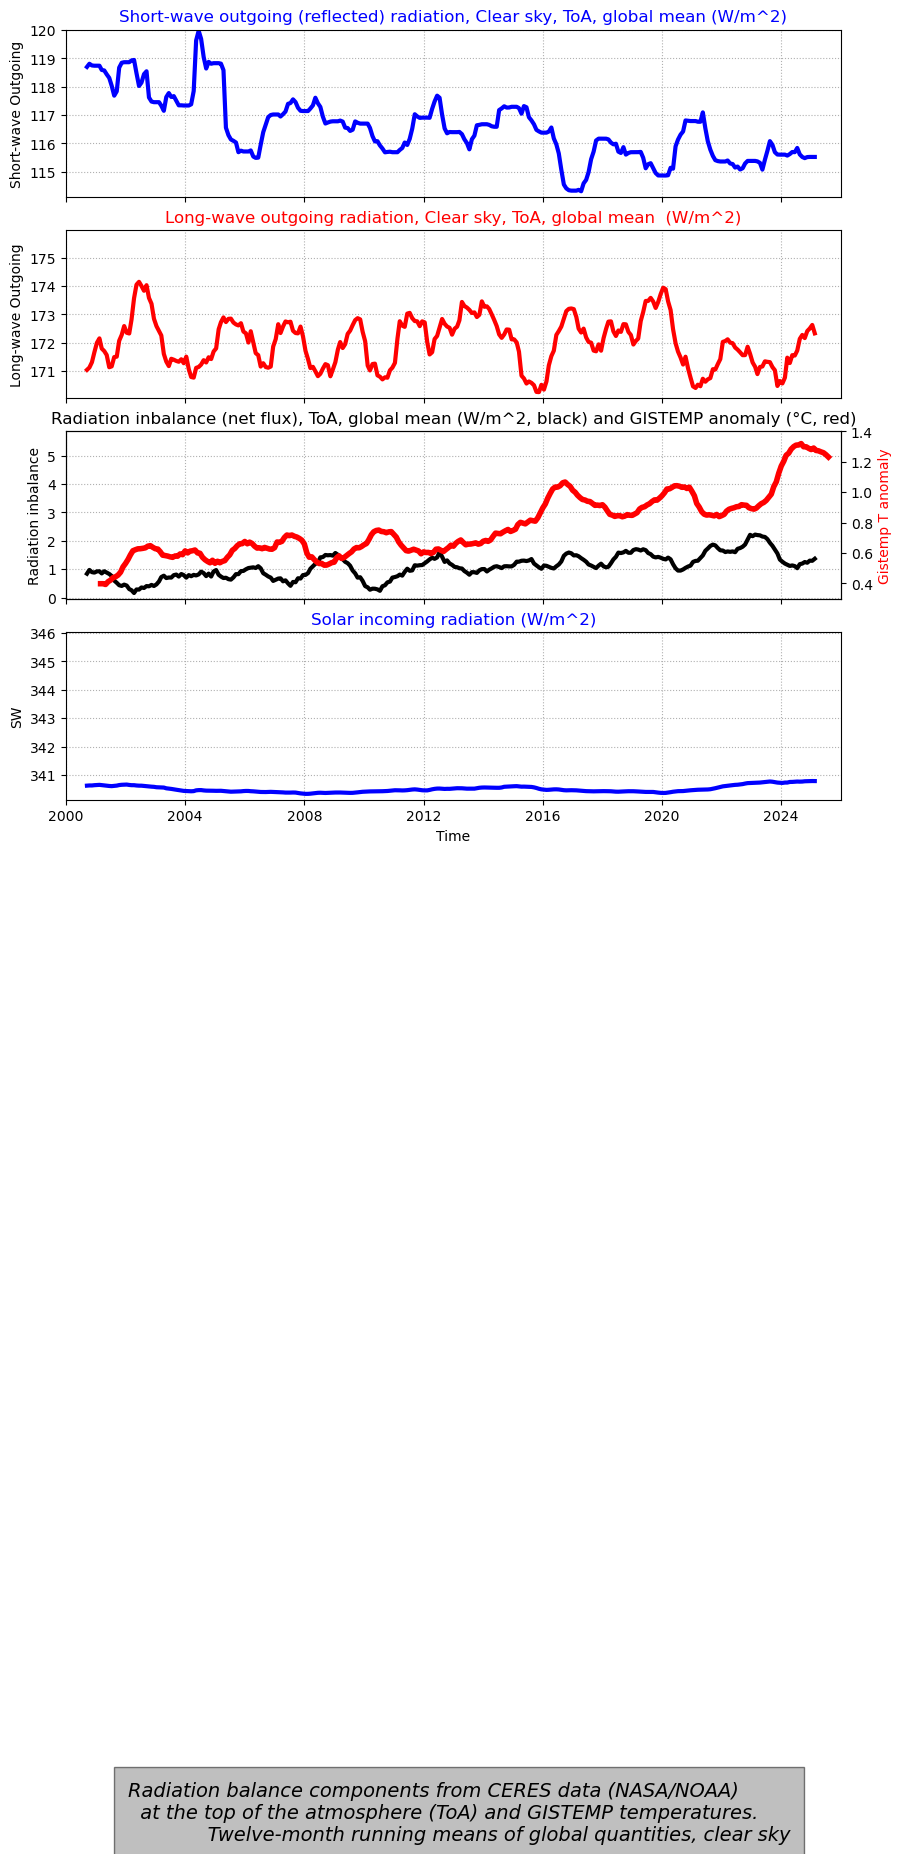

In [32]:

# Plotting:
   
plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(4, sharex=True)

ylim_range = 5.7
ylim_offset = 0.2

# English version:

axs[0].plot(sw_weighted_mean.time, sw_weighted_mean_smoothed, color="blue", linewidth=3)
axs[0].set_ylim(float(sw_weighted_mean_smoothed.min()) - ylim_offset, 
            float(sw_weighted_mean_smoothed.min() + ylim_range))
axs[0].set_ylabel('Short-wave Outgoing')
axs[0].set_title('Short-wave outgoing (reflected) radiation, Clear sky, ToA, global mean (W/m^2)', color="blue")
axs[0].set_xlim(datetime(2000,1,1), datetime(2026,1,1))
axs[0].grid('on', which='major', axis='y', linestyle=':')
axs[0].grid('on', which='major', axis='x', linestyle=':')
axs[0].text(datetime(2002, 2, 1), 56.2, '''Radiation balance components from CERES data (NASA/NOAA) 
  at the top of the atmosphere (ToA) and GISTEMP temperatures.
             Twelve-month running means of global quantities, clear sky''',
            style='italic',
            bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=14)
# axs[0].text(datetime(2016, 1, 1), 99.5, 'Data NASA/NOAA, author: M. Šálek', style='italic',
#         bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10}, fontsize=8)


axs[1].plot(lw_weighted_mean.time, lw_weighted_mean_smoothed, color="red",linewidth=3)
axs[1].set_ylim(float(lw_weighted_mean_smoothed.min())  - ylim_offset, 
            float(lw_weighted_mean_smoothed.min() + ylim_range))
axs[1].set_ylabel('Long-wave Outgoing')
axs[1].set_title('Long-wave outgoing radiation, Clear sky, ToA, global mean  (W/m^2)', color = 'red')
axs[1].grid('on', which='major', axis='y', linestyle=':')
axs[1].grid('on', which='major', axis='x', linestyle=':')
# axs[1].text(datetime(2016, 1, 1), 240, 'Data NASA/NOAA, author: M. Šálek', style='italic',
#         bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10}, fontsize=8)
axs[2].plot(toa_net_weighted_mean.time, toa_net_weighted_mean_smoothed,
            color="black", linewidth=3)

# Adding Gistemp temperature anomaly
axs[2].plot(toa_net_weighted_mean, color="black", linewidth=2)
axs[2].set_ylim(float(toa_net_weighted_mean_smoothed.min())  - ylim_offset, 
            float(toa_net_weighted_mean_smoothed.min() + ylim_range))
axs[2].set_title('Radiation inbalance (net flux), ToA, global mean (W/m^2, black) and GISTEMP anomaly (°C, red)')
axs[2].grid('on', which='major', axis='y', linestyle=':')
axs[2].grid('on', which='major', axis='x', linestyle=':')
# axs[2].text(datetime(2016, 1, 1), 0.3, 'Data NASA/NOAA, author: M. Šálek', style='italic',
#         bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10}, fontsize=8)

ax2b = axs[2].twinx()
# Adding Gistemp temperature anomaly
ax2b.plot(gistemp_months_smoothed.time, gistemp_months_smoothed,
            color="red", linewidth=4)
ax2b.set_ylim(0.3, 1.4) 
axs[2].set_ylabel('Radiation inbalance', color='black', fontsize = 10)
ax2b.set_ylabel('Gistemp T anomaly', color='red', fontsize = 10)

axs[2].grid('on', which='major', axis='y', linestyle=':')
axs[2].grid('on', which='major', axis='x', linestyle=':')
axs[3].plot(solar_incmg_weighted_mean.time, solar_incmg_weighted_mean_smoothed.data, color="blue", linewidth=3)
axs[3].set_xlabel('Time')
axs[3].set_ylim(float(solar_incmg_weighted_mean_smoothed.min())  - ylim_offset, 
            float(solar_incmg_weighted_mean_smoothed.min() + ylim_range))
axs[3].set_ylabel('SW')
axs[3].set_title('Solar incoming radiation (W/m^2)', color="blue")
axs[3].set_xlim(datetime(2000,1,1), datetime(2026,1,1))
axs[3].grid('on', which='major', axis='y', linestyle=':')
axs[3].grid('on', which='major', axis='x', linestyle=':')
# axs[3].text(datetime(2016, 1, 1), 341.7, 'Data NASA/NOAA, author: M. Šálek', style='italic',
#         bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10}, fontsize=8)

fig.savefig("CERES_radiation_fluxes_globe_ENG_clear_sky_polars.png")

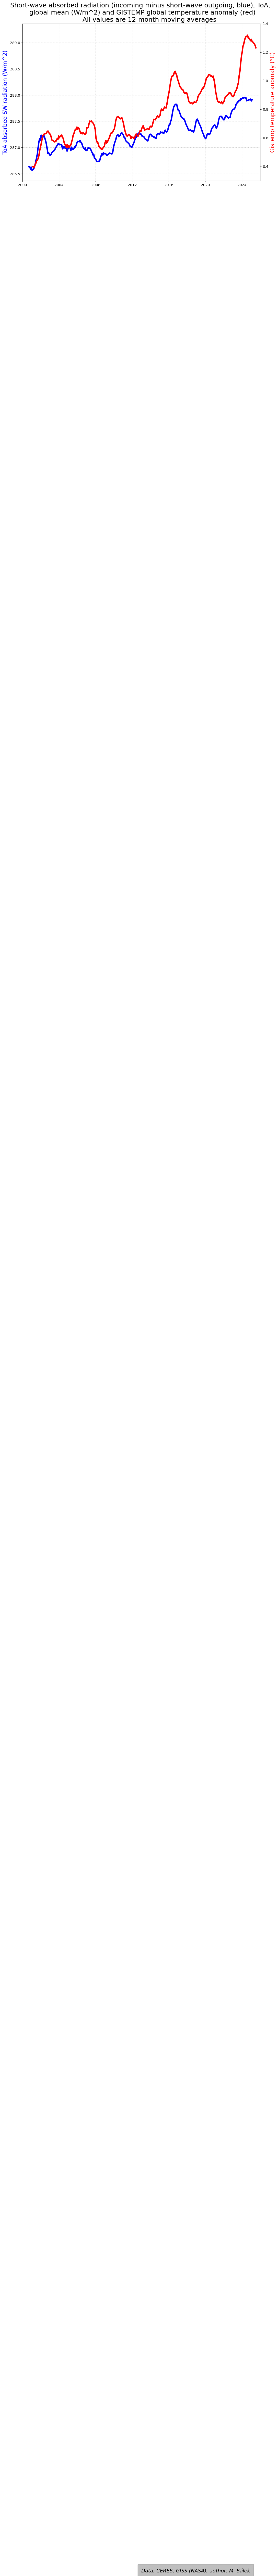

In [74]:
#################################################
# Absorbed radiation and GISTEM temperature
#################################################

ylim_range = 2.8
ylim_offset = 0.2
# Calculation of the absorbed energy (incoming solar irradiance minus outgoing short-wave radiatio)
absorbed_weighted_mean_smoothed = solar_incmg_weighted_mean_smoothed - sw_weighted_mean_smoothed

# print (absorbed_weighted_mean_smoothed)
# print (gistemp_months_smoothed)

# print (type(absorbed_weighted_mean_smoothed))
# print (type(gistemp_months_smoothed))

fig, ax = plt.subplots(1, sharex=True)
#ax.set_aspect(1.5)
ax.plot(absorbed_weighted_mean_smoothed.time, absorbed_weighted_mean_smoothed, color="blue", linewidth=4)
ax.set_ylim(float(absorbed_weighted_mean_smoothed.min()) - ylim_offset, 
            float(absorbed_weighted_mean_smoothed.min() + ylim_range))
ax.set_title('''Short-wave absorbed radiation (incoming minus short-wave outgoing, blue), ToA, 
 global mean (W/m^2) and GISTEMP global temperature anomaly (red)
        All values are 12-month moving averages''', 
             color="black", fontsize = 18)
ax.set_xlim(datetime(2000,1,1), datetime(2026,1,1))
ax.grid('on', which='major', axis='y', linestyle=':')
ax.grid('on', which='major', axis='x', linestyle=':')
ax.text(datetime(2013, 1, 1), 240.7, '''Data: CERES, GISS (NASA), author: M. Šálek''',
            style='italic',
            bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=14)

ax2 = ax.twinx()
# Adding Gistemp temperature anomaly
ax2.plot(toa_net_weighted_mean.time, gistemp_months_smoothed,
            color="red", linewidth=4)
ax2.set_ylim(0.3, 1.4) 
ax.set_ylabel('ToA absorbed SW radiation (W/m^2)', color='blue', fontsize = 16)
ax2.set_ylabel('Gistemp temperature anomaly (°C)', color='red', fontsize = 16)

ax.grid('on', which='major', axis='y', linestyle=':')
ax.grid('on', which='major', axis='x', linestyle=':')
# ax[0].text(datetime(2016, 1, 1), 0.3, 'Data NASA/NOAA, author: M. Šálek', style='italic',
#         bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10}, fontsize=8)
fig.set_size_inches(12, 8)
# fig.savefig("CERES_abs_sw_radiation_fluxes_globe_and_gistemp.png")